# 하이브리드 추천방식 활용
1. KMeans로 군집화
2. 군집 내에서 가장 유사한 10명의 유저 추출 (Cosine 유사도)

## 0.라이브러리

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import cosine_similarity

## 1. 데이터 로드 & 전처리 컬럼 설정

In [18]:
df = pd.read_csv('../data/VL_CSV/tn_traveller_master_여행객 Master_E.csv')

In [19]:
# 사용할 컬럼 정의
categorical_cols = [
    'GENDER', 'EDU_NM', 'EDU_FNSH_SE', 'MARR_STTS', 'JOB_NM',
    'INCOME', 'HOUSE_INCOME', 'TRAVEL_TERM',
    'TRAVEL_LIKE_SIDO_1', 'TRAVEL_LIKE_SIDO_2', 'TRAVEL_LIKE_SIDO_3',
    'TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3', 'TRAVEL_STYL_4',
    'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_7', 'TRAVEL_STYL_8',
    'TRAVEL_MOTIVE_1', 'TRAVEL_MOTIVE_2'
]

numerical_cols = [
    'AGE_GRP', 'FAMILY_MEMB', 'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM'
]

use_cols = categorical_cols + numerical_cols

# 전처리용 데이터 필터링 (결측치 제거)
df_filtered = df[use_cols].dropna()

## 2. 전처리 및 군집화 파이프라인 작성

In [20]:
# 전처리 파이프라인
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# 클러스터링 포함 파이프라인 (8개 클러스터 기준)
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('cluster', KMeans(n_clusters=8, random_state=42))
])

# 학습
pipeline.fit(df_filtered)

# 클러스터 결과 저장
df_filtered['cluster'] = pipeline.named_steps['cluster'].labels_

## 3. 군집 내 유사 유저 추출

In [ ]:
# 원본 데이터에서 전처리 후 유저 ID 등 다시 붙이기 위해 인덱스 저장
df_with_id = df.copy()
df_filtered = df[use_cols].dropna()
df_filtered['cluster'] = pipeline.named_steps['cluster'].labels_

# cluster index를 활용해 원본 데이터 반환
def recommend_similar_users_in_cluster(user_data: dict, top_n: int = 10):
    input_df = pd.DataFrame([user_data])[use_cols]
    input_vec = pipeline.named_steps['preprocess'].transform(input_df)
    
    # 클러스터 예측
    predicted_cluster = pipeline.named_steps['cluster'].predict(input_vec)[0]

    # 해당 클러스터 내 유저 추출 (index 기준)
    cluster_indices = df_filtered[df_filtered['cluster'] == predicted_cluster].index
    cluster_users = df_with_id.loc[cluster_indices] 

    # 전처리 벡터로 유사도 계산
    cluster_vecs = pipeline.named_steps['preprocess'].transform(df_filtered.loc[cluster_indices][use_cols])
    sim_scores = cosine_similarity(input_vec, cluster_vecs)[0]
    top_indices = np.argsort(sim_scores)[::-1][:top_n]

    return cluster_users.iloc[top_indices].copy()


## 4. 테스트

In [25]:
example_user = {
    'GENDER': '여',
    'EDU_NM': 4,
    'EDU_FNSH_SE': 1,
    'MARR_STTS': 3,
    'JOB_NM': 11,
    'INCOME': 4,
    'HOUSE_INCOME': 9,
    'TRAVEL_TERM': 2,
    'TRAVEL_LIKE_SIDO_1': 11,
    'TRAVEL_LIKE_SIDO_2': 47,
    'TRAVEL_LIKE_SIDO_3': 41,
    'TRAVEL_STYL_1': 2,
    'TRAVEL_STYL_2': 4,
    'TRAVEL_STYL_3': 4,
    'TRAVEL_STYL_4': 4,
    'TRAVEL_STYL_5': 4,
    'TRAVEL_STYL_6': 4,
    'TRAVEL_STYL_7': 5,
    'TRAVEL_STYL_8': 5,
    'TRAVEL_MOTIVE_1': 2,
    'TRAVEL_MOTIVE_2': 6,
    'AGE_GRP': 20,
    'FAMILY_MEMB': 3,
    'TRAVEL_NUM': 2,
    'TRAVEL_COMPANIONS_NUM': 1
}

top_users = recommend_similar_users_in_cluster(example_user, top_n=10)

# 확인
print(top_users[['TRAVELER_ID', 'AGE_GRP', 'TRAVEL_STATUS_DESTINATION']])


     TRAVELER_ID  AGE_GRP TRAVEL_STATUS_DESTINATION
1358     e003394       30                        경기
1771     e004338       30                        서울
74       e004655       30                        서울
2512     e000433       20                        인천
740      e003300       20                        서울
868      e006869       20                        경기
744      e007227       20                        서울
2270     e004551       30                        서울
307      e001428       30                        서울
1563     e002220       30                        경기


## 5. 군집 시각화

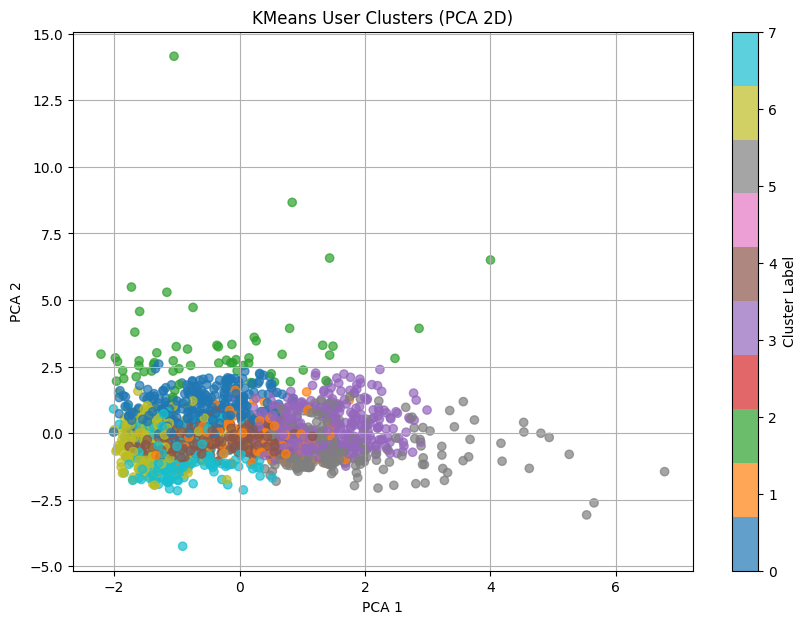

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_all = pipeline.named_steps['preprocess'].transform(df_filtered[use_cols])
cluster_labels = df_filtered['cluster'].values

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_all)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)

plt.title("KMeans User Clusters (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster Label")
plt.grid(True)
plt.show()

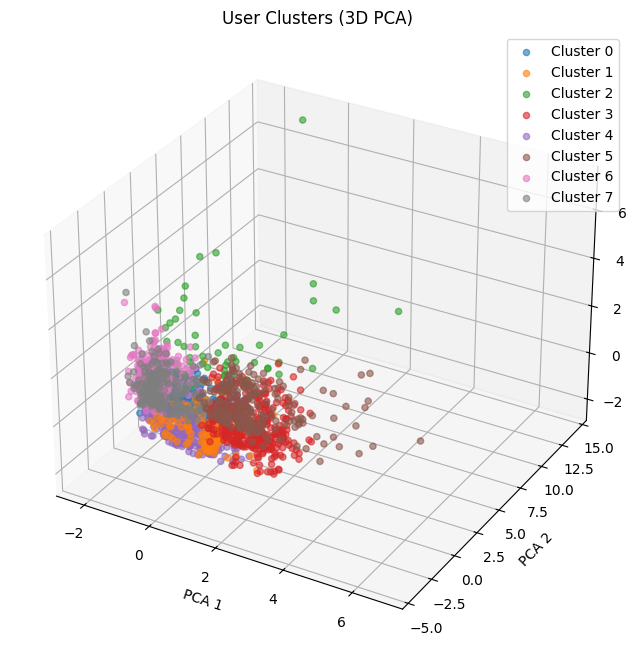

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt  
import seaborn as sns

X_all = pipeline.named_steps['preprocess'].transform(df_filtered[use_cols])
cluster_labels = df_filtered['cluster'].values

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_all)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette('tab10', len(np.unique(cluster_labels)))

# 산점도
for i, label in enumerate(np.unique(cluster_labels)):
    cluster_points = X_pca[cluster_labels == label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
               c=[colors[i]], label=f'Cluster {label}', alpha=0.6)

ax.set_title("User Clusters (3D PCA)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.legend()
plt.show()


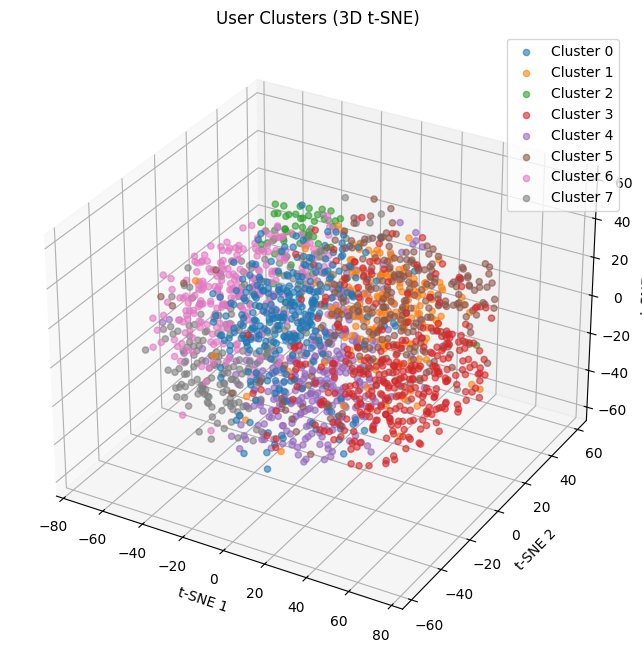

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_all)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(np.unique(cluster_labels)):
    cluster_points = X_tsne[cluster_labels == label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
               c=[colors[i]], label=f'Cluster {label}', alpha=0.6)

ax.set_title("User Clusters (3D t-SNE)")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.legend()
plt.show()
